In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
import datetime
import h5py
import pickle
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
from keras_contrib.layers import CRF

# Load and process data for train sample generation

In [3]:
def load_data(hdf5_path):
    with h5py.File(hdf5_path, 'r') as hf:
        x = hf.get('x')
        y = hf.get('y')
        video_id_list = hf.get('video_id_list')
        x = np.array(x)
        y = list(y)
        video_id_list = list(video_id_list)
        
    return x, y, video_id_list

def uint8_to_float32(x):
    return (np.float32(x) - 128.) / 128.
    
def bool_to_float32(y):
    return np.float32(y)

In [5]:
# read data (some samples of music) - it is separate dataset with 1000 track with 30 seconds length with differen genres
with open("geres_dump.pkl","rb") as handle:
    data_dict_music = pickle.load(handle)
    
embedings_list = data_dict_music["embedings_list"]

# define some params
seq_length = embedings_list[0].shape[0]
embed_dim = embedings_list[0].shape[1]
music_data_new = np.zeros((len(embedings_list),seq_length,embed_dim),dtype=np.float32)
for i in range(len(embedings_list)):
    music_data_new[i,:,:] = embedings_list[i]
    
music_data_new = uint8_to_float32(music_data_new)

In [6]:
# load small sybset of AudioSet samples

(x, y, video_id_list) = load_data('./AudioSet/packed_features/bal_train.h5')
x = uint8_to_float32(x)# shape: (N, 10, 128)
y = bool_to_float32(y)# shape: (N, 527)

In [7]:
# find speech and sing labels
labels = pd.read_csv("./AudioSet/class_labels_indices.csv")
speech_labels = labels[labels["is_speaking"] == 1]["index"].values
music_labels = labels[labels["is_singing"] == 1]["index"].values

In [8]:
# collect all speech records

music_idxs = []
speech_idxs = []

for i,val in tqdm(enumerate(y)):
    nnz_idxs = val.nonzero()[0]
    if any([idx in music_labels for idx in nnz_idxs]): 
        music_idxs.append(i)
    if any([idx in speech_labels for idx in nnz_idxs]): 
        speech_idxs.append(i)

22160it [00:00, 29043.99it/s]


In [9]:
music_set = set(music_idxs)
speech_set = set(speech_idxs)
music_set_clear = music_set.difference(speech_set)
speech_set_clear = speech_set.difference(music_set)

In [10]:
# collect arrays for speech and singing

music_data = np.zeros((len(music_set_clear),10,128),dtype=np.float32)
speech_data = np.zeros((len(speech_set_clear),10,128), dtype=np.float32)

for i,idx in enumerate(music_set_clear):
    music_data[i,:,:] = x[idx,:,:]
    
for i, idx in enumerate(speech_set_clear):
    speech_data[i,:,:] = x[idx,:,:]

In [298]:
# reshape 31 frames data to 10 sec frames

music_data_new_res = music_data_new.reshape(3100,10,128)

In [299]:
# add data to sample

music_data = np.vstack([music_data,music_data_new_res])

In [13]:
def generate_data_sample(music_data,speech_data, N_music_min, 
                         N_music_max, N_speech_min, N_speech_max,
                         N_samples=10000, seq_len=100, embed_dim=128):
    
    number_tracks = int(round(seq_len)/10)
    data_sample = np.zeros((N_samples,seq_len,embed_dim),dtype=np.float32)
    mask_sample = np.zeros((N_samples,seq_len,1),dtype=np.float32)
    for i in tqdm(range(N_samples)):
        # generat audio features
        
        for k in range(number_tracks):
            rand_idx = np.random.randint(N_speech_min, N_speech_max)
            data_sample[i,10*k:10*(k+1),:] = speech_data[rand_idx,:,:]
    
        # randomly select position for music part
    
        start = np.random.randint(int(-0.2*seq_len),int(1.2*seq_len))
        duration = np.random.randint(seq_len)
        finish = start + duration
        if start < 0:
            start = 0
        if finish < 0:
            continue
        if start < seq_len:
            if finish > seq_len:
                finish = seq_len
            mask_sample[i,start:finish,0] = 1.0
            curr_music_len = finish - start
            while curr_music_len > 10:
                rand_idx = np.random.randint(N_music_min, N_music_max)
                data_sample[i,start:start+10,:] = music_data[rand_idx,:,:]
                start += 10
                curr_music_len = finish - start
            rand_idx = np.random.randint(N_music_min,N_music_max)
            data_sample[i,start:finish,:] = music_data[rand_idx,:curr_music_len,:]
    return data_sample, mask_sample

In [14]:
# generate train, val and test data

N_music = len(music_set_clear)
N_speech = len(speech_set_clear)

# train
tr_data, y_tr = generate_data_sample(music_data,speech_data,N_music_min=0,N_music_max=int(N_music*0.64),
                                     N_speech_min=0, N_speech_max=int(0.64*N_speech), N_samples=30000)

val_data,y_val = generate_data_sample(music_data,speech_data,N_music_min=int(N_music*0.64),N_music_max=int(N_music*0.8),
                                     N_speech_min=int(0.64*N_speech), N_speech_max=int(0.8*N_speech), N_samples=5000)

te_data, y_te = generate_data_sample(music_data,speech_data,N_music_min=int(N_music*0.8),N_music_max=N_music,
                                     N_speech_min=int(0.8*N_speech), N_speech_max=N_speech, N_samples=5000)

100%|██████████| 5000/5000 [00:00<00:00, 14229.27it/s]


# Build keras model

In [15]:
import keras
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent,Conv1D,SpatialDropout1D,Reshape
from keras.layers.wrappers import Bidirectional
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Activation
from keras.optimizers import RMSprop, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.wrappers import Bidirectional
from keras import backend as K
from keras.layers import Input,GRU, Layer
from keras.layers.merge import add, concatenate, dot
from keras.models import Model
from keras.layers.pooling import AveragePooling1D,GlobalAveragePooling1D
from keras.layers import GaussianDropout

In [16]:
# build simple keras model

seq_len = 100
embed_dim = 128

model = Sequential()
model.add(Layer(input_shape=(None,embed_dim,)))
#model.add(GaussianDropout(0.05))
#model.add(TimeDistributed(Dense(16, activation = 'relu')))
model.add(Bidirectional(GRU(64,recurrent_dropout=0.2,return_sequences=True)))
model.add(Dropout(0.2))
#model.add(GaussianDropout(0.05))
#model.add(Bidirectional(GRU(64,recurrent_dropout=0.2,return_sequences=True)))
#model.add(GaussianDropout(0.05))
#model.add(Dropout(0.2))
#model.add(TimeDistributed(Dense(16, activation = 'relu')))
model.add(TimeDistributed(Dense(1, activation = 'sigmoid')))


model.compile(loss='binary_crossentropy',
             optimizer='adam',
            metrics=['accuracy'])

In [ ]:
# define scheduler

from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
lr_scheduler_callback = LearningRateScheduler(lambda epoch:
                                                      0.001 if epoch < 3
                                                      else 0.0003)

In [ ]:
# train model

filepath = './model_cpt/model_LG_None_gru_64_new_split_do_slow_sch_new_songs.h5'
my_callback = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only=False, mode='auto')
model.fit(tr_data, y_tr,batch_size=32,
          validation_data = (val_data,y_val),
          epochs=30,
          callbacks = [my_callback, lr_scheduler_callback,EarlyStopping(monitor='val_loss', patience = 3, verbose = 0)])

In [ ]:
#load model

from keras.models import load_model
model = load_model("./model_cpt/model_LG_None_gru_64_new_split_do_fast_sch_new_songs.h5")
#model = load_model("./model_cpt/model_LG_None_gru_64_new_split_do_slow_sch_new_songs.h5")
#model = load_model("./model_cpt/model_LG_None_gru_128_new_split_do_fast_sch.h5")

# CRF as a last layer

In [21]:
# define model with CRF

seq_len = 100
embed_dim = 128

input = Input(shape=(None,embed_dim,))
model = Bidirectional(GRU(units=64, return_sequences=True,
                           recurrent_dropout=0.2))(input)  # variational biGRU
model = Dropout(0.2)(model)
model = TimeDistributed(Dense(16, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf_layer = CRF(2)  # CRF layer
out = crf_layer(model)  # output

In [24]:
model = Model(input, out)
model.compile(optimizer="adam", loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 128)         74112     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 16)          2064      
_________________________________________________________________
crf_1 (CRF)                  (None, None, 2)           42        
Total params: 76,218
Trainable params: 76,218
Non-trainable params: 0
_________________________________________________________________


In [36]:
# convert data for CRF format

from keras.utils import to_categorical
crf_y_tr = [to_categorical(i, num_classes=2) for i in y_tr]
crf_y_val = [to_categorical(i, num_classes=2) for i in y_val]

crf_y_tr = np.array(crf_y_tr)
crf_y_val = np.array(crf_y_val)

In [38]:
# define learning rate schedule

from keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping
lr_scheduler_callback = LearningRateScheduler(lambda epoch:
                                                      0.001 if epoch < 3
                                                      else 0.0003)

In [39]:
# train and save model

filepath = './model_cpt/model_LG_None_gru_64_new_split_do_crf_slow_sch_new_songs.h5'
my_callback = keras.callbacks.ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0, save_best_only = True, save_weights_only=False, mode='auto')
model.fit(tr_data, crf_y_tr,batch_size=32,
          validation_data = (val_data,crf_y_val),
          epochs=30,
          callbacks = [my_callback, lr_scheduler_callback,EarlyStopping(monitor='val_loss', patience = 3, verbose = 1)])

Train on 30000 samples, validate on 5000 samples
Epoch 1/30
30000/30000 [==============================] - 166s 6ms/step - loss: 0.0450 - acc: 0.9788 - val_loss: 0.0489 - val_acc: 0.9786

In [42]:
#make some preparation to properly load objects from keras_contribute

from keras_contrib.layers import CRF
from keras.models import load_model

def create_custom_objects():
    instanceHolder = {"instance": None}
    class ClassWrapper(CRF):
        def __init__(self, *args, **kwargs):
            instanceHolder["instance"] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)
    def loss(*args):
        method = getattr(instanceHolder["instance"], "loss_function")
        return method(*args)
    def accuracy(*args):
        method = getattr(instanceHolder["instance"], "accuracy")
        return method(*args)
    return {"ClassWrapper": ClassWrapper ,"CRF": ClassWrapper, "loss": loss, "accuracy":accuracy}

In [43]:
from keras.models import load_model

model = load_model("./model_cpt/model_LG_None_gru_64_new_split_do_crf_slow_sch_new_songs.h5",custom_objects=create_custom_objects())

# Work with real data

In [343]:
with open("voice_sample.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [275]:
with open("lacuna_coil_sample.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [246]:
with open("awg.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [366]:
with open("epica.pkl","rb") as handle:
    data_dict_new = pickle.load(handle)

In [367]:
real_sample = data_dict_new["embedings_list"]

In [368]:
real_sample = real_sample[0]
real_sample = real_sample.reshape((1,real_sample.shape[0],real_sample.shape[1]))

In [369]:
real_sample = uint8_to_float32(real_sample)

In [370]:
real_lns = real_sample.shape[1]
tracks = int(real_lns/seq_len)
real_mask = np.zeros((real_lns,1),dtype=np.float32)
for i in range(tracks):
    q = model.predict(real_sample[:,i*seq_len:(i+1)*seq_len,:])
    q = q[0,:,0]
    real_mask[i*seq_len:(i+1)*seq_len,0]=q
q = model.predict(real_sample[:,tracks*seq_len:,:])
q = q[0,:,0]
real_mask[tracks*seq_len:,0]= q

In [371]:
real_mask = real_mask.reshape(-1)

In [372]:
# use gaussian convolution for smoothing mask

from astropy.convolution import Gaussian1DKernel, convolve

# Create kernel
g = Gaussian1DKernel(stddev=5)

# Convolve data
smooth_mask = convolve(real_mask, g, boundary='extend')

In [373]:
smooth_mask = [1-v for v in smooth_mask]
real_mask = [1-v for v in real_mask]

In [374]:
q = [int(t > 0.3) for t in smooth_mask]

In [375]:
idxs = np.nonzero(q)[0]

In [376]:
def aggregate_intervals(idxs,max_lag=4):
    
    fragments_list = []
    start_segment = idxs[0]
    finish_segment = idxs[0]
    prev_val = idxs[0]
    for v in idxs:
        if v - prev_val < max_lag:
            prev_val = v
            finish_segment = v
        else:
            if finish_segment - start_segment > 10:
                fragments_list.append([start_segment,finish_segment])
                start_segment = v
                finish_segment = v
                prev_val = v
            else:
                start_segment = v
                finish_segment = v
                prev_val = v
    if finish_segment - start_segment > 10:
        fragments_list.append([start_segment,finish_segment])
    return fragments_list

def sec_2_time(s):
    return str(datetime.timedelta(seconds=s))

def transform_to_time(res):
    intervals = [[sec_2_time(int(0.96*q)) for q in v] for v in res]
    return intervals

In [377]:
res = aggregate_intervals(idxs)
res = transform_to_time(res)

In [378]:
res

[['0:00:07', '0:04:10'],
 ['0:04:56', '0:08:44'],
 ['0:09:43', '0:13:20'],
 ['0:13:49', '0:17:25']]

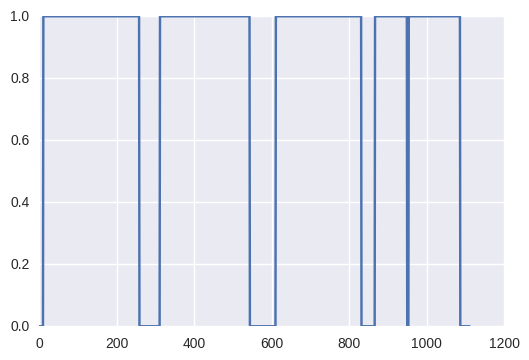

In [379]:
plt.plot([l for l in range(len(real_mask))], real_mask)

In [380]:
q

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


# Hardcoded labeling

In [381]:
#epica

ratio = 100/96
true_value = np.zeros(len(q),dtype=np.float32)
true_value[int(11*ratio):int(248*ratio) + 1] = 1.0
true_value[int(300*ratio):int(524*ratio) + 1] = 1.0
true_value[int(587*ratio):int(798*ratio) + 1] = 1.0
true_value[int(832*ratio):int((17*60+25)*ratio) + 1] = 1.0

In [290]:
# lacuna coil

ratio = 100/96
true_value = np.zeros(len(q),dtype=np.float32)
true_value[int(73*ratio):int(148*ratio) + 1] = 1.0
true_value[int(193*ratio):int(247*ratio) + 1] = 1.0
true_value[int(276*ratio):int(337*ratio) + 1] = 1.0
true_value[int(396*ratio):int(411*ratio) + 1] = 1.0

In [358]:
# Voice India

ratio = 100/96
true_value = np.zeros(len(q),dtype=np.float32)
true_value[int(50*ratio):int(61*ratio) + 1] = 1.0
true_value[int(103*ratio):int(110*ratio) + 1] = 1.0
true_value[int(195*ratio):int(222*ratio) + 1] = 1.0
true_value[int(195*ratio):int(222*ratio) + 1] = 1.0
true_value[int(264*ratio):int(281*ratio) + 1] = 1.0
true_value[int(296*ratio):int(302*ratio) + 1] = 1.0
true_value[int(312*ratio):int(343*ratio) + 1] = 1.0
true_value[int(312*ratio):int(343*ratio) + 1] = 1.0
true_value[int(374*ratio):int(419*ratio) + 1] = 1.0
true_value[int(471*ratio):int(495*ratio) + 1] = 1.0
true_value[int(639*ratio):int(651*ratio) + 1] = 1.0
true_value[int(653*ratio):int(709*ratio) + 1] = 1.0
true_value[int(711*ratio):int(778*ratio) + 1] = 1.0
true_value[int(783*ratio): ] = 1.0

# Model evaluation on some samples

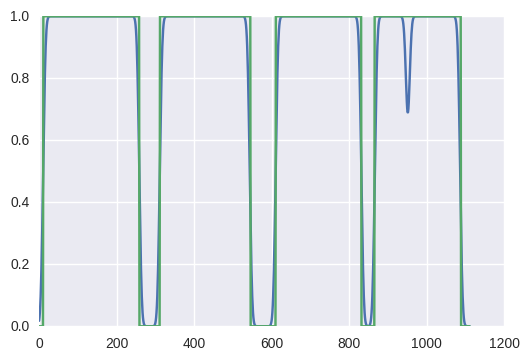

In [382]:
#evaluaion on epica

plt.plot([l for l in range(len(real_mask))], smooth_mask, [l for l in range(len(real_mask))], true_value)

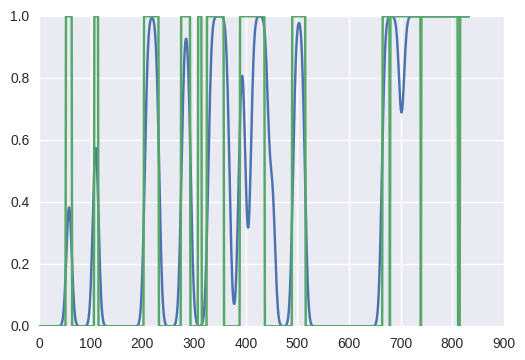

In [359]:
# evalutaion on Voice India

plt.plot([l for l in range(len(smooth_mask))], smooth_mask, [l for l in range(len(smooth_mask))], true_value)

In [383]:
np.corrcoef(smooth_mask, true_value)

array([[1.        , 0.96500353],
       [0.96500353, 1.        ]])

In [361]:
from sklearn.metrics import log_loss, f1_score, r2_score,confusion_matrix, classification_report,roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}
results = {"nn":real_mask,"smooth_nn":smooth_mask}
for k in results:
    fpr[k],tpr[k] ,_ = roc_curve(true_value, results[k])
    roc_auc[k] = auc(fpr[k], tpr[k])

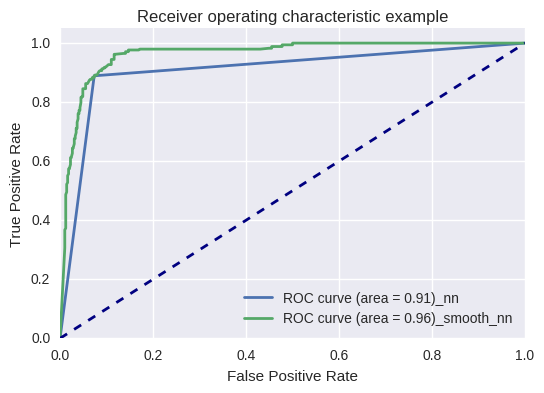

In [362]:
plt.figure()
for k in results:
    plt.plot(fpr[k], tpr[k],
             lw=2, label='ROC curve (area = %0.2f)_{}'.format(k) % roc_auc[k])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()